     orf_id  Essential upstream_size downstream_size paralagous_count  \
0  YAL001C           1      >365.00        <=968.00           <=0.00    
1  YAL002W           0      >365.00        <=968.00           <=0.00    
2  YAL003W           1      >365.00        <=968.00           <=0.00    
3  YAL005C           0      >365.00         >968.00            >2.00    
4  YAL007C           0      >365.00        <=968.00     (0.00, 2.00]    

   phyletic_retention promoter_count(Harbison_et_al) DIP_degree       PI  \
0                   2                       <=58.00     <=4.00    >6.13    
1                   2                        >58.00     <=4.00   <=6.13    
2                   4                        >58.00     <=4.00   <=6.13    
3                   4                       <=58.00      >4.00   <=6.13    
4                   3                       <=58.00      >4.00   <=6.13    

        CAI  ... microtubule mitochondrion nuclear periphery nucleolus  \
0  <=0.146   ...           0  

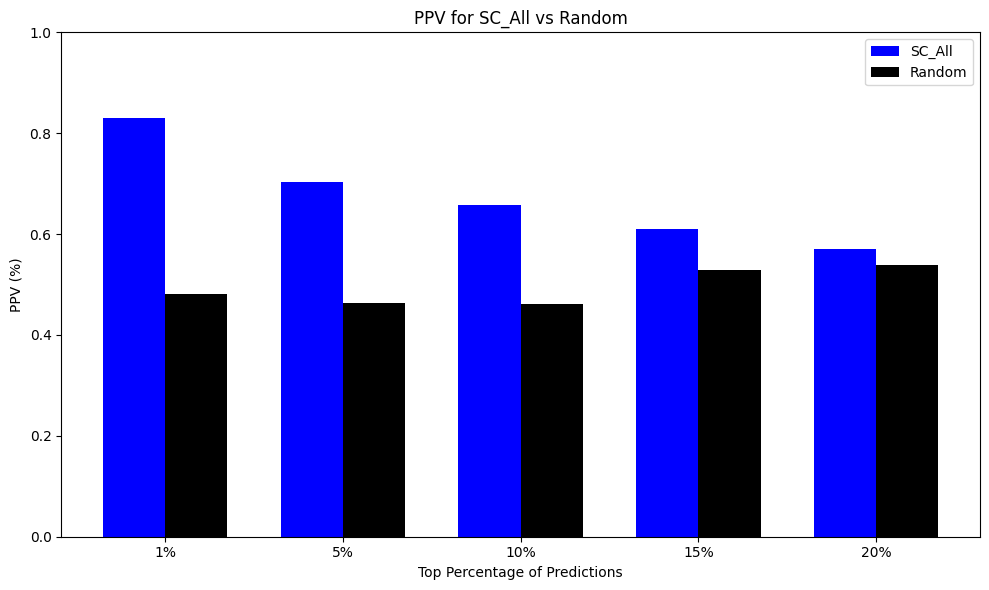

Optimal number of features: 6


In [24]:
# Aggiornamento del codice per i punti 3, 4 e 5
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Funzione per calcolare PPV al top percentili
def calculate_top_percentile_ppv(probabilities, true_labels, percentiles):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = true_labels[sorted_indices]
    ppv_percentiles = []

    for p in percentiles:
        n_top = int(len(sorted_labels) * (p / 100))
        top_labels = sorted_labels[:n_top]
        ppv = np.sum(top_labels) / len(top_labels) if len(top_labels) > 0 else 0
        ppv_percentiles.append(ppv)

    return ppv_percentiles



# def load_data():
#     # Carica i dati
#     data = pd.read_excel('cerevisiae_data.xls')
#     X = data.drop(columns=['Essential', 'orf_id'])
#     y = data['Essential']
#     return X, y


def load_discretized_data():
    # Carichiamo i dati dallo sheet 2
    file_path = './cerevisiae_data.xls'
    discretized_data = pd.read_excel(file_path, sheet_name='entropy discretized')

    # Mostriamo un esempio dei dati per verificare
    print(discretized_data.head())

    # Identificare le colonne con simboli/intervalli
    columns_with_symbols = discretized_data.columns[2:]  # Saltiamo "orf_id" e "Essential"

    # Creare un dizionario per salvare i LabelEncoder
    label_encoders = {}

    # Trasformare ogni colonna con valori discreti
    for column in columns_with_symbols:
        le = LabelEncoder()
        discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
        label_encoders[column] = le  # Salviamo per referenze future

    # Controlliamo il risultato
    print(discretized_data.head())

    # returns x,y
    return discretized_data.drop(columns=['Essential', 'orf_id']), discretized_data['Essential']


# Caricamento dei dati
X, y = load_discretized_data()




# Ranking CMIM fornito
CMIM_ranking = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus', 'nucleus',
                'upstream_size', 'spindle pole', 'GLU', 'Codon_bias', 'aromaticity_score', 'Gravy_score',
                'CAI', 'downstream_size', 'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP', 'ER to Golgi', 'GLN',
                'peroxisome', 'num places loc', 'LYS', 'ambiguous', 'cell periphery', 'FOP_score', 
                'nuclear periphery', 'ARG', 'Golgi to ER', 'punctate composite', 'ER', 'lipid particle',
                'microtubule', 'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']
X_ranked = X[CMIM_ranking]

# Discretizzazione
n_bins = 3
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Percentuali per PPV
percentiles = [1, 5, 10, 15, 20]

# Bootstrap
n_iterations = 100
optimal_features = None
highest_ppv_1 = 0
highest_ppv_5 = 0

gene_probabilities = np.zeros(len(y))

for i in range(len(CMIM_ranking), 0, -1):
    X_selected = X_ranked.iloc[:, :i]
   # X_discretized = discretizer.fit_transform(X_selected)
    X_discretized = X_selected.values

    ppv_1_scores = []
    ppv_5_scores = []

    for _ in range(n_iterations):
        # Bootstrap: campionamento con rimpiazzo
        X_train, X_test, y_train, y_test = train_test_split(X_discretized, y, test_size=0.5, stratify=y)

        # Modello Naive Bayes
        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train, y_train)

        # Probabilità predette
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
        ppv_top = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), percentiles)

        ppv_1_scores.append(ppv_top[0])
        ppv_5_scores.append(ppv_top[1])

        # Aggiornamento delle probabilità globali
        gene_indices = y_test.index
        gene_probabilities[gene_indices] += y_prob

    # Condizione per cutoff ottimale
    mean_ppv_1 = np.mean(ppv_1_scores)
    mean_ppv_5 = np.mean(ppv_5_scores)

    if mean_ppv_1 > highest_ppv_1 and mean_ppv_5 > highest_ppv_5:
        highest_ppv_1 = mean_ppv_1
        highest_ppv_5 = mean_ppv_5
        optimal_features = i

# Calcola la probabilità media per ciascun gene
gene_probabilities /= n_iterations

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))

# PPV per SC_All e Random
sc_all_ppv = calculate_top_percentile_ppv(gene_probabilities, y.to_numpy(), percentiles)
random_ppv = [np.random.uniform(0.45, 0.55) for _ in percentiles]

# Barre
width = 0.35
labels = [f'{p}%' for p in percentiles]
ax.bar(np.arange(len(percentiles)) - width/2, sc_all_ppv, width, label='SC_All', color='blue')
ax.bar(np.arange(len(percentiles)) + width/2, random_ppv, width, label='Random', color='black')

# Etichette e titolo
ax.set_xlabel('Top Percentage of Predictions')
ax.set_ylabel('PPV (%)')
ax.set_title('PPV for SC_All vs Random')
ax.set_xticks(np.arange(len(percentiles)))
ax.set_xticklabels(labels)
ax.legend()

# show in y axis the percentage from 0 to 100
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"Optimal number of features: {optimal_features}")
